# Sparkify Project

# Business understanding

Sparkify is a fictional music platform. Sparkify project is a part of Udacity Data Science Nanodegree program. The goal of the project is to analyze user behavior and predict which users will cancel their subscriptions. Paid accounts contribute to company's revenue and it is significant to identify customers that may churn. To explore and analyze the data, I used Apache Spark.

For this project, the dataset was first examined to gain insights into its structure and quality. I used tiny subset (128MB) of the full dataset available (12GB).

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count,round,asc,desc

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Apply the changes to the current session
import os

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



In [2]:
# create a Spark session
os.environ['JAVA_HOME'] = '/workspace/jdk'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

spark = SparkSession.builder.appName("Sparkify Project").getOrCreate()

/opt/venv/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/05 11:43:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset

In [3]:
# Load the mini dataset
file_path = "mini_sparkify_event_data.json"
df = spark.read.json(file_path)
# df.show(5) 

# Exploratory Data Analysis

### Data Understanding

#### Describe data

In [4]:
df.toPandas().head(4)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [5]:
# check schema of df
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# check rows and columns lenght
df.count(), len(df.columns)

(286500, 18)

In [7]:
# check missing data
df.select([count(when(isnan(column) | col(column).isNull(), column)).alias(column) for column in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [8]:
#check values of particular string columns
df.select('auth').distinct().show(), df.select('gender').distinct().show(),\
df.select('level').distinct().show() ,df.select('location').distinct().show(),\
df.select('method').distinct().show(), df.select('page').distinct().show(),\
df.select('userAgent').distinct().show(), df.select('userID').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



+------+
|gender|
+------+
|     F|
|     M|
|  NULL|
+------+



+-----+
|level|
+-----+
| free|
| paid|
+-----+



+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



+------+
|method|
+------+
|   PUT|
|   GET|
+------+



+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



+------+
|userID|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



(None, None, None, None, None, None, None, None)

In [9]:
# check usedID, location and page in more details
df.select('userID').distinct().collect(), df.select('location').distinct().collect(), df.select('page').distinct().collect()

([Row(userID='100010'),
  Row(userID='200002'),
  Row(userID='125'),
  Row(userID='51'),
  Row(userID='124'),
  Row(userID='7'),
  Row(userID='54'),
  Row(userID='15'),
  Row(userID='155'),
  Row(userID='132'),
  Row(userID='154'),
  Row(userID='100014'),
  Row(userID='101'),
  Row(userID='11'),
  Row(userID='138'),
  Row(userID='300017'),
  Row(userID='29'),
  Row(userID='69'),
  Row(userID='100021'),
  Row(userID='42'),
  Row(userID='112'),
  Row(userID='87'),
  Row(userID='73'),
  Row(userID='64'),
  Row(userID='200010'),
  Row(userID='3'),
  Row(userID='30'),
  Row(userID='113'),
  Row(userID='34'),
  Row(userID='133'),
  Row(userID='59'),
  Row(userID='146'),
  Row(userID='139'),
  Row(userID='8'),
  Row(userID='28'),
  Row(userID='22'),
  Row(userID='300018'),
  Row(userID='300012'),
  Row(userID='100022'),
  Row(userID='85'),
  Row(userID='52'),
  Row(userID='35'),
  Row(userID='16'),
  Row(userID='300008'),
  Row(userID='71'),
  Row(userID='98'),
  Row(userID='300013'),
  Row(u

In [10]:
# check how many rows in userID column are not a number
my_values = ['0', '1', '2', '3','4', '5','6', '7','8', '9',]
regex_values = "|".join(my_values)
df.select('userID').filter(~df['userID'].rlike(regex_values)).count()

8346

In [4]:
df.createOrReplaceTempView("tbl_df")

In [12]:
spark.sql('''
        SELECT count(userId) as a 
        FROM tbl_df
        where userId like ('')
        
        ''').show()

+----+
|   a|
+----+
|8346|
+----+



I will delete rows with userId = '' during data cleaning

In [13]:
# describe numeric columns 
df.describe('itemInSession').show(), df.describe('length').show(), df.describe('registration').show(),\
df.describe('sessionId').show(), df.describe('status').show(), df.describe('ts').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834084427...|
| stddev| 3.291321616327586E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+



+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



+-------+------------------+
|summary|            status|
+-------+------------------+
|  count|            286500|
|   mean|210.05459685863875|
| stddev| 31.50507848842214|
|    min|               200|
|    max|               404|
+-------+------------------+

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



(None, None, None, None, None, None)

#### Clean data

In [5]:
# delete rows with missing userID
df_clean = df.filter(df['userId']!='')

In [15]:
# check missing data after cleaning userID column
df_clean.select([count(when(isnan(column) | col(column).isNull(), column)).alias(column) for column in df_clean.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


There are missing data in artist, length and song columns. I will check them in more details

In [16]:
df_clean.createOrReplaceTempView("tbl_df_clean")

In [17]:
# check if null values in artist, length and song columns are in the same rows
df_test = spark.sql('''
        SELECT * 
        FROM tbl_df_clean
        where artist is null
        
        ''')

In [18]:
df_test.select([count(when(isnan(column) | col(column).isNull(), column)).alias(column) for column in df_test.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


All null values in artist, length and song columns are in the same rows. It seems that those users are not listening to the music while using Sparkify. I will keep those rows as they may be important

In [6]:
# save userID as number
df_clean = df_clean.withColumn('userId', col('userId').cast(LongType()))

In [7]:
# split location column. I will take only state name as the location
df_clean = df_clean.withColumn('location', split(col('location'),',').getItem(1))

In [8]:
# remove special characters from all string columns eg artist
def remove_specials(df):
    for col in df.schema.fields:
        if col.dataType==StringType():
            df = df.withColumn(col.name, regexp_replace(col.name, '[^a-zA-Z0-9\,\-]', ''))
            
    return df



In [9]:
df_clean = remove_specials(df_clean)

In [23]:
# check for artist clumn
df_clean.select('artist').filter(df_clean.artist.like('%Ismo%')).show()

+-------------+
|       artist|
+-------------+
|IsmoAlankoSti|
|IsmoAlankoSti|
|   IsmoAlanko|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|   IsmoAlanko|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
|   IsmoAlanko|
|IsmoAlankoSti|
|IsmoAlankoSti|
|IsmoAlankoSti|
+-------------+
only showing top 20 rows



In [10]:
# create new ts columns. Those will be used later to calculate new features
# 1. ts_new - more readable date
df_clean = df_clean.withColumn('ts_new', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
# 2. month
df_clean = df_clean.withColumn('month', month(col('ts_new')))
# 3. date
df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))

In [11]:
# create new registration column for better readibility
df_clean = df_clean.withColumn('registration_new', from_unixtime(col('registration').cast(LongType())/1000).cast(TimestampType()))

In [26]:
df_clean.toPandas().head(4)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,ts_new,month,date,registration_new
0,MarthaTilston,LoggedIn,Colin,M,50,Freeman,277.89016,paid,CA,PUT,...,29,Rockpools,200,1538352117000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:01:57,10,2018-10-01,2018-09-28 22:22:42
1,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,MA-NH,PUT,...,8,Canada,200,1538352180000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:03:00,10,2018-10-01,2018-09-30 18:20:30
2,AdamLambert,LoggedIn,Colin,M,51,Freeman,282.82730,paid,CA,PUT,...,29,TimeForMiracles,200,1538352394000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:06:34,10,2018-10-01,2018-09-28 22:22:42
3,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,MA-NH,PUT,...,8,KnockingOnForbiddenDoors,200,1538352416000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:06:56,10,2018-10-01,2018-09-30 18:20:30


### Define churn

In [12]:
df_clean.createOrReplaceTempView("tbl_df_clean")

In [13]:
# define churn using Cancellation Confirmation values in page column. 
# If a user eves had Cancellation Confirmation status then it is a churn.
# 1- churn, 0- not churn

df_churn = spark.sql('''
        SELECT userId,
               MAX(IF(page = "CancellationConfirmation",1,0)) as churn
        FROM tbl_df_clean
        GROUP BY userId
        
        ''')
df_churn.createOrReplaceTempView("tbl_df_churn")

In [14]:
# merge churn column with df_clean
df_clean = spark.sql('''
        SELECT a.*, b.churn
        FROM tbl_df_clean a
        LEFT JOIN tbl_df_churn b on a.userId = b.userId       
        ''')
df_clean.createOrReplaceTempView("tbl_df_clean")

In [30]:
# check df_clean for particular users
spark.sql('''
        SELECT *
        FROM tbl_df_clean
        where userId = 51
        
        ''').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,ts_new,month,date,registration_new,churn
0,None,LoggedIn,Ethan,M,6,Johnson,NaN,paid,KY,GET,...,None,200,1538398632000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-01 12:57:12,10,2018-10-01,2018-09-27 20:43:07,1
1,ErykahBadu,LoggedIn,Ethan,M,7,Johnson,289.69751,paid,KY,PUT,...,WindowSeat,200,1538398649000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-01 12:57:29,10,2018-10-01,2018-09-27 20:43:07,1
2,Blf,LoggedIn,Ethan,M,8,Johnson,229.82485,paid,KY,PUT,...,NietsDanDit,200,1538398938000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-01 13:02:18,10,2018-10-01,2018-09-27 20:43:07,1
3,MousseTVsHotnJuicy,LoggedIn,Ethan,M,9,Johnson,184.29342,paid,KY,PUT,...,Horny,200,1538399167000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-01 13:06:07,10,2018-10-01,2018-09-27 20:43:07,1
4,MirandaLambert,LoggedIn,Ethan,M,10,Johnson,144.14322,paid,KY,PUT,...,MeandYourCigarettes,200,1538399351000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-01 13:09:11,10,2018-10-01,2018-09-27 20:43:07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,IsmoAlankoSti,LoggedIn,Ethan,M,172,Johnson,218.93179,paid,KY,PUT,...,NokianTakana,200,1539761508000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-17 07:31:48,10,2018-10-17,2018-09-27 20:43:07,1
2460,Zox,LoggedIn,Ethan,M,173,Johnson,212.34893,paid,KY,PUT,...,CantLookDown,200,1539761726000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-17 07:35:26,10,2018-10-17,2018-09-27 20:43:07,1
2461,None,LoggedIn,Ethan,M,174,Johnson,NaN,paid,KY,GET,...,None,200,1539761829000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-17 07:37:09,10,2018-10-17,2018-09-27 20:43:07,1
2462,None,LoggedIn,Ethan,M,175,Johnson,NaN,paid,KY,PUT,...,None,307,1539761830000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,51,2018-10-17 07:37:10,10,2018-10-17,2018-09-27 20:43:07,1


In [31]:
spark.sql('''
        SELECT *
        FROM tbl_df_clean
        where userId = 9
        
        ''').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,ts_new,month,date,registration_new,churn
0,FiveIronFrenzy,LoggedIn,Micah,M,79,Long,236.09424,free,MA-NH,PUT,...,Canada,200,1538352180000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:03:00,10,2018-10-01,2018-09-30 18:20:30,0
1,Enigma,LoggedIn,Micah,M,80,Long,262.71302,free,MA-NH,PUT,...,KnockingOnForbiddenDoors,200,1538352416000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:06:56,10,2018-10-01,2018-09-30 18:20:30,0
2,TheAll-AmericanRejects,LoggedIn,Micah,M,81,Long,208.29995,free,MA-NH,PUT,...,DontLeaveMe,200,1538352678000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:11:18,10,2018-10-01,2018-09-30 18:20:30,0
3,TheVelvetUndergroundNico,LoggedIn,Micah,M,82,Long,260.46649,free,MA-NH,PUT,...,RunRunRun,200,1538352886000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:14:46,10,2018-10-01,2018-09-30 18:20:30,0
4,BrittNicole,LoggedIn,Micah,M,83,Long,229.87710,free,MA-NH,PUT,...,WalkOnTheWater,200,1538353146000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:19:06,10,2018-10-01,2018-09-30 18:20:30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186,ATeens,LoggedIn,Micah,M,148,Long,223.47710,paid,MA-NH,PUT,...,MammaMia,200,1543337772000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-11-27 16:56:12,11,2018-11-27,2018-09-30 18:20:30,0
3187,IrishTenors,LoggedIn,Micah,M,149,Long,187.48036,paid,MA-NH,PUT,...,DannyBoy,200,1543337995000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-11-27 16:59:55,11,2018-11-27,2018-09-30 18:20:30,0
3188,CrystalCastles,LoggedIn,Micah,M,150,Long,251.08853,paid,MA-NH,PUT,...,Empathy,200,1543338182000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-11-27 17:03:02,11,2018-11-27,2018-09-30 18:20:30,0
3189,None,LoggedIn,Micah,M,151,Long,NaN,paid,MA-NH,PUT,...,None,200,1543338189000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-11-27 17:03:09,11,2018-11-27,2018-09-30 18:20:30,0


In [15]:
df_clean.createOrReplaceTempView("tbl_df_clean")

### Explore aggregates on churn and non churn users

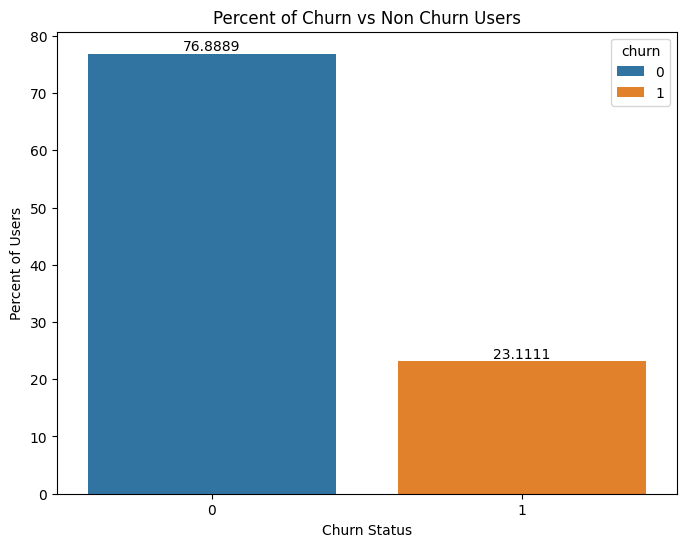

In [33]:
# churn vs non churn users. Percent of customers

n = df_clean.select('userId').dropDuplicates().count()

#calculate percent of total rows for each team
churn_no = df_clean.select('userId', 'churn').dropDuplicates().groupBy('churn').count().withColumn('churn_percent', (col('count')/n)*100)

# convert to Pandas DataFrame for visualization
churn_no_pd = churn_no.toPandas()

# plot churn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_no_pd, x='churn', y='churn_percent', hue='churn')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.title('Percent of Churn vs Non Churn Users')
plt.xlabel('Churn Status')
plt.ylabel('Percent of Users')
plt.show()

Dataset is imbalanced. There is 23% of churn users. 

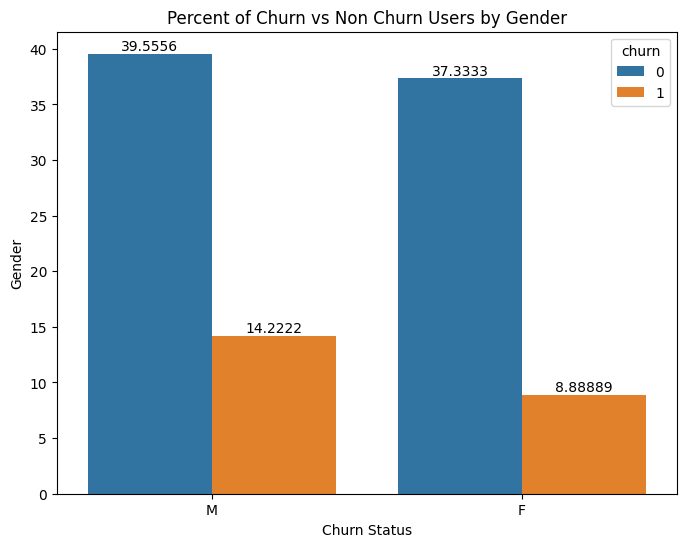

In [34]:
# Calculate churn rate by gender
n = df_clean.select('userID', 'gender','churn').distinct().count()

gender_churn = df_clean.select('userID', 'gender','churn').distinct().groupBy('gender','churn').count().withColumn('churn_percent', (col('count')/n)*100)

# convert to Pandas DataFrame for visualization
gender_churn_pd = gender_churn.toPandas()

# plot churn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=gender_churn_pd, x='gender', y='churn_percent', hue='churn')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.title('Percent of Churn vs Non Churn Users by Gender')
plt.xlabel('Churn Status')
plt.ylabel('Gender')
plt.show()

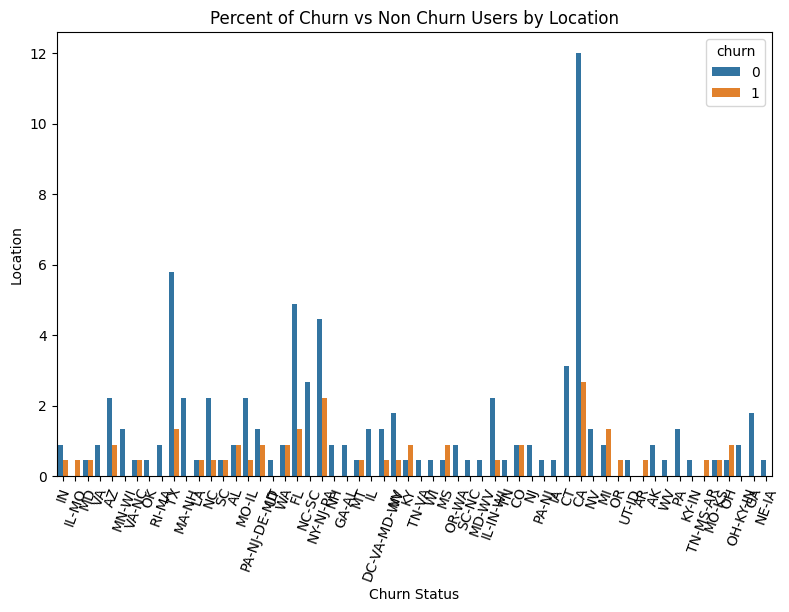

In [35]:
# Calculate churn rate by location
n = df_clean.select('userID', 'location','churn').distinct().count()

location_churn = df_clean.select('userID', 'location','churn').distinct().groupBy('location','churn').count().withColumn('churn_percent', (col('count')/n)*100)

# convert to Pandas DataFrame for visualization
location_churn_pd = location_churn.toPandas()

# plot churn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=location_churn_pd, x='location', y='churn_percent', hue='churn')

plt.xticks(rotation=70)
plt.tight_layout()
    
plt.title('Percent of Churn vs Non Churn Users by Location')
plt.xlabel('Churn Status')
plt.ylabel('Location')
plt.show()

In [36]:
# additional check for Cancelled status in auth column.
df_clean.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
| LoggedIn|
+---------+



In [37]:
df_clean.select('userID', 'auth','churn').distinct().show()

+------+---------+-----+
|userID|     auth|churn|
+------+---------+-----+
|   120| LoggedIn|    0|
|    90| LoggedIn|    0|
|    27| LoggedIn|    0|
|   117| LoggedIn|    0|
|    76| LoggedIn|    0|
|    19| LoggedIn|    0|
|200001| LoggedIn|    1|
|    94| LoggedIn|    0|
|    56| LoggedIn|    0|
|200011|Cancelled|    1|
|    54| LoggedIn|    1|
|   102| LoggedIn|    0|
|    73|Cancelled|    1|
|200015|Cancelled|    1|
|   129|Cancelled|    1|
|    79| LoggedIn|    0|
|   121| LoggedIn|    1|
|    24| LoggedIn|    0|
|200003| LoggedIn|    0|
|    40| LoggedIn|    0|
+------+---------+-----+
only showing top 20 rows



There are users that have double auth status in the same ts. We should show last auth status of a user using ts column

In [38]:
auth_status = spark.sql('''
        SELECT a.userId, a.ts, a.auth, a.churn 
        FROM tbl_df_clean a 
        INNER JOIN (SELECT userId, max(ts) as ts
                    FROM tbl_df_clean
                    group by userId) b on a.userId = b.userId and a.ts = b.ts
        
        ''')
auth_status.createOrReplaceTempView("tbl_auth_status")

In [39]:
# check users that have duoble auth status in the same ts
spark.sql('''
        SELECT a.*, b.user_cnt
        FROM tbl_auth_status a
        LEFT JOIN (select userId, count(userId) user_cnt
                            from tbl_auth_status
                            group by userID) b on a.userId = b.userId
        where b.user_cnt>1
    
        
        ''').toPandas()

,userId,ts,auth,churn,user_cnt
0,127,1543351229000,LoggedIn,0,2
1,127,1543351229000,LoggedIn,0,2
2,125,1539318918000,Cancelled,1,2
3,125,1539318918000,LoggedIn,1,2


There are two users with double status in the same ts. For user 125 I will keep row that indicates churn (to not to lose churn flag). For the 127 user I will delete last row.  

In [16]:
df_clean = spark.sql('''
        SELECT *
        FROM tbl_df_clean
        where not ((userId = 125 and auth = 'LoggedIn' and ts = 1539318918000) 
                    or (userId = 127 and auth = 'LoggedIn' and ts = 1543351229000 and method = 'GET'))
        
        ''')
df_clean.createOrReplaceTempView("tbl_df_clean")

In [17]:
# latest auth status
auth_status_df = spark.sql('''
        SELECT a.userId, a.ts, a.auth 
        FROM tbl_df_clean a 
        INNER JOIN (SELECT userId, max(ts) as ts
                    FROM tbl_df_clean
                    group by userId) b on a.userId = b.userId and a.ts = b.ts
        
        ''')
auth_status_df.createOrReplaceTempView("tbl_auth_status_df")

In [18]:
# join latest auth status as latest_auth to df_clean and drop original auth column
df_clean = spark.sql('''
        SELECT a.*, b.auth as latest_auth
        FROM tbl_df_clean a
        left join (select * from tbl_auth_status_df) b on a.userId = b.userId
        ''')
# drop oryginal auth column
df_clean = df_clean.drop('auth')

df_clean.createOrReplaceTempView("tbl_df_clean")

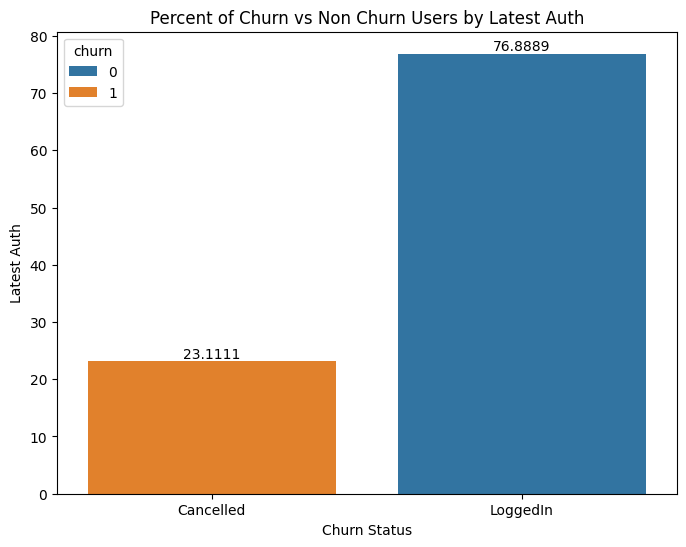

In [43]:
# Calculate churn rate by latests auth
n = df_clean.select('userID', 'latest_auth','churn').distinct().count()

auth_churn = df_clean.select('userID', 'latest_auth','churn').distinct().groupBy('latest_auth','churn').count().withColumn('churn_percent', (col('count')/n)*100)

# convert to Pandas DataFrame for visualization
auth_churn_pd = auth_churn.toPandas()

# plot churn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=auth_churn_pd, x='latest_auth', y='churn_percent', hue='churn')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.title('Percent of Churn vs Non Churn Users by Latest Auth')
plt.xlabel('Churn Status')
plt.ylabel('Latest Auth')
plt.show()

As there is no difference between latest auth and churn column I will delete latest auth column from data set

In [19]:
df_clean = df_clean.drop('latest_auth')

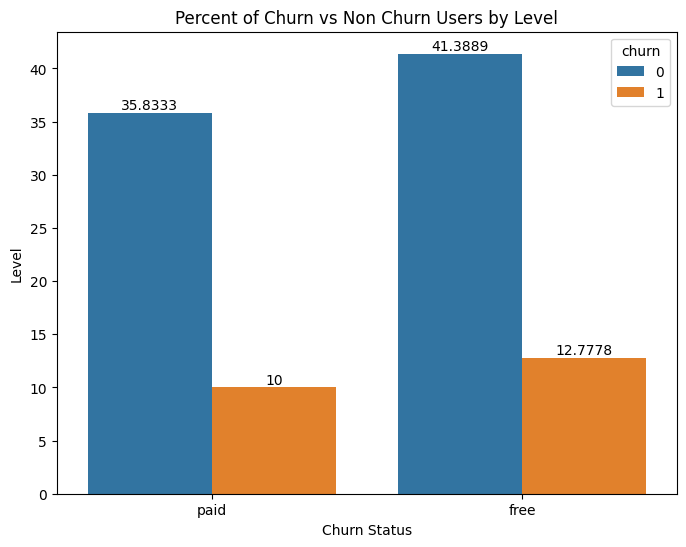

In [45]:
# Calculate churn rate by level
n = df_clean.select('userID', 'level','churn').distinct().count()

level_churn = df_clean.select('userID', 'level','churn').distinct().groupBy('level','churn').count().withColumn('churn_percent', (col('count')/n)*100)

# convert to Pandas DataFrame for visualization
level_churn_pd = level_churn.toPandas()

# plot churn
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=level_churn_pd, x='level', y='churn_percent', hue='churn')

for i in ax.containers:
    ax.bar_label(i,)
    
plt.title('Percent of Churn vs Non Churn Users by Level')
plt.xlabel('Churn Status')
plt.ylabel('Level')
plt.show()

# Feature Engineering

In [46]:
df_clean.toPandas().head(4)

,artist,firstName,gender,itemInSession,lastName,length,level,location,method,page,...,song,status,ts,userAgent,userId,ts_new,month,date,registration_new,churn
0,MarthaTilston,Colin,M,50,Freeman,277.89016,paid,CA,PUT,NextSong,...,Rockpools,200,1538352117000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:01:57,10,2018-10-01,2018-09-28 22:22:42,0
1,FiveIronFrenzy,Micah,M,79,Long,236.09424,free,MA-NH,PUT,NextSong,...,Canada,200,1538352180000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:03:00,10,2018-10-01,2018-09-30 18:20:30,0
2,AdamLambert,Colin,M,51,Freeman,282.82730,paid,CA,PUT,NextSong,...,TimeForMiracles,200,1538352394000,Mozilla50WindowsNT61WOW64rv310Gecko20100101Fir...,30,2018-10-01 00:06:34,10,2018-10-01,2018-09-28 22:22:42,0
3,Enigma,Micah,M,80,Long,262.71302,free,MA-NH,PUT,NextSong,...,KnockingOnForbiddenDoors,200,1538352416000,Mozilla50WindowsNT61WOW64AppleWebKit53736KHTML...,9,2018-10-01 00:06:56,10,2018-10-01,2018-09-30 18:20:30,0


In [20]:
# month of last interaction
last_interaction_df = df_clean.groupBy('userId').agg(max('ts_new').alias('last_interaction')).withColumn('month_last_interaction', month(col('last_interaction')))

In [21]:
# registration length per user
df_clean = last_interaction_df.join(df_clean, on='userId').withColumn('registration_length', ((col('last_interaction')-col('registration_new'))/(24*3600)).cast(IntegerType()))

In [22]:
#  number of artists listened per user
artists_df = df_clean.select('userId', 'artist').distinct().groupBy('userId').count().select('userId', col('count').alias('n_artists'))

In [23]:
# number of songs played per user
songs_df = df_clean.select('userId', 'song').groupBy('userId').count().select('userId', col('count').alias('n_songs'))

In [24]:
# latest page status before churn
from pyspark.sql import Window

page_df = df_clean.select('userId', 'page', 'ts', 'churn').orderBy('userId', 'ts', ascending=False)

w = Window.partitionBy('userId').orderBy(desc('ts'))

page_df = page_df.withColumn("1st_value", nth_value("page", 1).over(w)).withColumn("2nd_value", nth_value("page", 2).over(w))

In [25]:
page_df.createOrReplaceTempView("tbl_page_df") 

In [26]:
page_df = spark.sql('''
        SELECT * FROM (
        SELECT distinct userId,
               case when churn = 1 then 2nd_value else 1st_value end as latest_page_before_churn
        FROM tbl_page_df)
        where latest_page_before_churn IS NOT NULL
        
        ''')
page_df.createOrReplaceTempView("tbl_page_df")

In [27]:
# latest level status
level_df = df_clean.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('last_level'))

In [28]:
# average item(song) length per user
avg_length_df = df_clean.groupBy('userId').avg('length').withColumnRenamed('avg(length)', 'avg_length')

In [29]:
# daily average sessions per user
daily_ses_df = df_clean.groupby('userId','date').agg(countDistinct('sessionId')).\
                groupBy('userId').avg('count(DISTINCT sessionId)').\
                withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_daily_ses_no')
    


In [30]:
# monthly average sessions per user
monthly_ses_df = df_clean.groupby('userId','month').agg(countDistinct('sessionId')).\
                    groupBy('userId').avg('count(DISTINCT sessionId)').\
                    withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_monthly_ses_no')

In [31]:
# average items listened in session per user
avg_itemInSession_df = df_clean.groupBy('userId').avg('itemInSession').withColumnRenamed('avg(itemInSession)', 'avg_itemInSession')

In [32]:
# daily average session length per user
daily_ses_length_df = df_clean.groupby('userId','date','sessionId').\
                    agg(max('ts').alias('max_ts'), min('ts').alias('min_ts')).\
                    withColumn('ses_length_sec', (col('max_ts')-col('min_ts'))*0.001).\
                    groupby('userId','date').avg('ses_length_sec').\
                    groupby('userId').agg(mean('avg(ses_length_sec)').alias('avg_daily_ses_length'))

In [33]:
# monthly average items listened in session per user
monthly_ses_length_df = df_clean.groupby('userId','month','sessionId').\
                    agg(max('ts').alias('max_ts'), min('ts').alias('min_ts')).\
                    withColumn('ses_length_sec', (col('max_ts')-col('min_ts'))*0.001).\
                    groupby('userId','month').avg('ses_length_sec').\
                    groupby('userId').agg(mean('avg(ses_length_sec)').alias('avg_monthly_ses_length'))

In [34]:
# number of events per each user and page status
page_status_no_df = df_clean.groupBy('userId').pivot('page').count().fillna(0)

Each user has one gender and one location. There are no multiplied rows in df_clean

In [35]:
#join new features into df_clean
df_feat = df_clean.join(artists_df, on='userId').join(songs_df, on='userId').join(level_df, on='userId')\
                    .join(avg_length_df, on='userId').join(avg_itemInSession_df, on='userId')\
                    .join(daily_ses_df, on='userId').join(monthly_ses_df, on='userId')\
                    .join(daily_ses_length_df, on='userId').join(monthly_ses_length_df, on='userId')\
                    .join(page_df, on='userId')
#                     .join(page_status_no_df, on='userId')\
                    

In [36]:
df_feat.createOrReplaceTempView("tbl_df_feat") 

25/03/05 11:44:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [64]:
spark.sql('''
        SELECT churn, latest_page_before_churn, count(latest_page_before_churn)
        FROM tbl_df_feat
        group by churn, latest_page_before_churn
        ''').show()

+-----+------------------------+-------------------------------+
|churn|latest_page_before_churn|count(latest_page_before_churn)|
+-----+------------------------+-------------------------------+
|    0|                NextSong|                          55777|
|    1|              RollAdvert|                             10|
|    0|                   About|                           2299|
|    0|                    Help|                           1672|
|    0|                ThumbsUp|                          21815|
|    1|                  Cancel|                          44853|
|    0|               AddFriend|                          19495|
|    0|              RollAdvert|                           5388|
|    0|                  Logout|                          31157|
|    0|                    Home|                          60887|
|    0|           AddtoPlaylist|                          25374|
|    0|               Downgrade|                           7530|
|    0|              Thum

In [39]:
spark.sql('''
        SELECT churn, month_last_interaction, count(month_last_interaction)
        FROM tbl_df_feat
        group by churn, month_last_interaction
        ''').show()

+-----+----------------------+-----------------------------+
|churn|month_last_interaction|count(month_last_interaction)|
+-----+----------------------+-----------------------------+
|    1|                    11|                        27866|
|    0|                    10|                         1305|
|    0|                    11|                       222340|
|    1|                    10|                        16997|
|    0|                    12|                         9644|
+-----+----------------------+-----------------------------+



For the great majority of users latest page status before churn is Cancel. I will drop this feature from analysis as it could be additional label for churn.

In [37]:
# drop unnecessary columns
# firstName, lastName has been dropped as we identyfi usar by user id
# 'ts', 'registration', 'last_interaction', 'ts_new', 'month', 'date', 'registration_new' has been removed as I used them to calculate new features
# 'artist',  'itemInSession', 'length', 'page', 'sessionId', 'song',   'level' has been removed as I used them to calculate new features
# 'method', 'status', 'userAgent', have been dropped to avoid complexity
df_feat = df_feat.drop('firstName', 'lastName', 
'ts', 'registration', 'last_interaction', 'ts_new', 'month', 'date', 'registration_new',
'artist',  'itemInSession', 'length', 'page', 'sessionId', 'song', 'level',
'method', 'status', 'userAgent', 'latest_page_before_churn', 'userId').dropDuplicates()

In [66]:
# check if we do not have rows doubled
df_feat.count(), len(df_feat.columns)

(225, 14)

In [38]:
df_feat = df_feat.withColumnRenamed('churn', 'label')

In [68]:
df_feat.columns

['month_last_interaction',
 'gender',
 'location',
 'label',
 'registration_length',
 'n_artists',
 'n_songs',
 'last_level',
 'avg_length',
 'avg_itemInSession',
 'avg_daily_ses_no',
 'avg_monthly_ses_no',
 'avg_daily_ses_length',
 'avg_monthly_ses_length']

I will plot features used in modelling despite those plotted earlier (gender, location, level)

In [ ]:
num_columns = []
for field in df_feat.schema.fields :
    num_columns.append(field.name)

# Elements to remove
remove = ['gender', 'location','last_level']

# Remove elements using list comprehension
num_columns = [x for x in num_columns if x not in remove]

In [93]:
pd_feat = df_feat.toPandas()

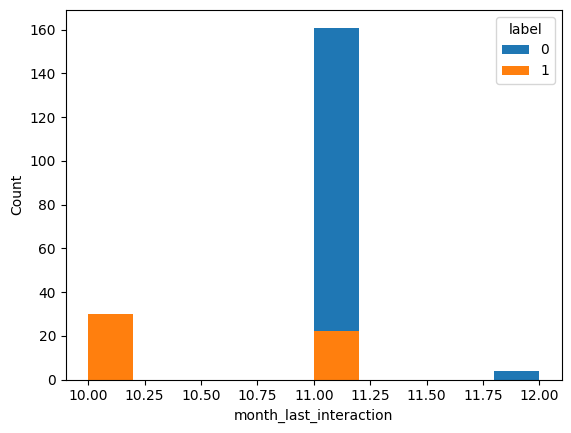

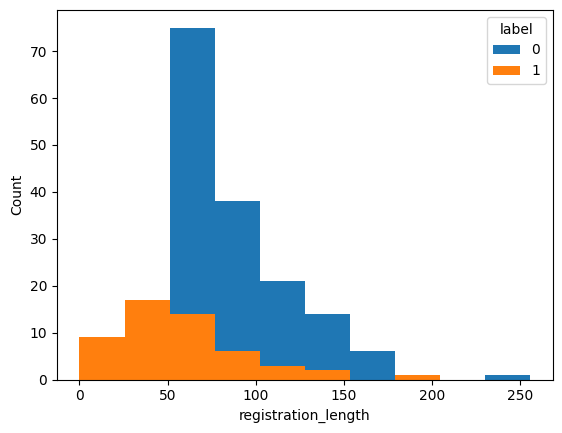

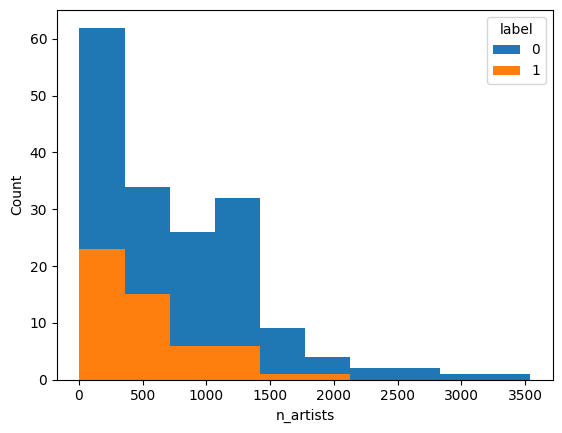

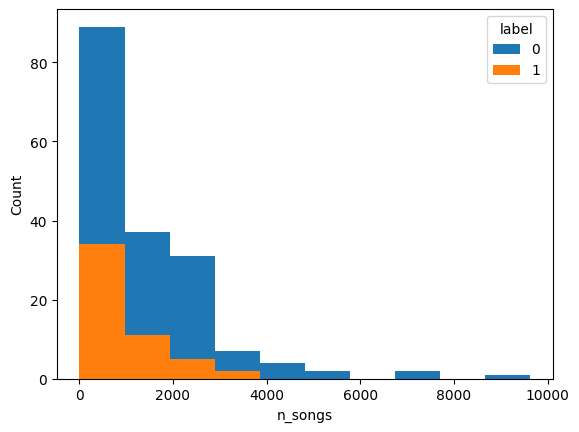

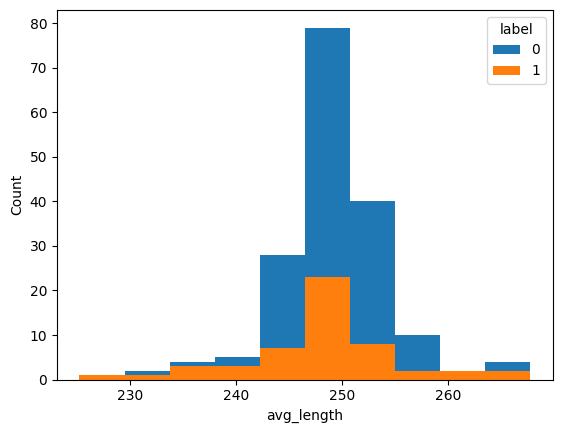

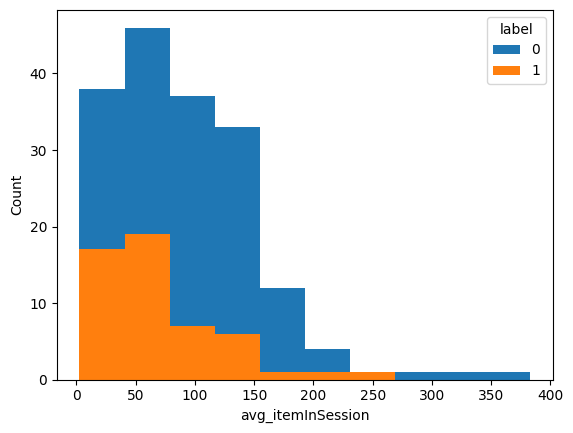

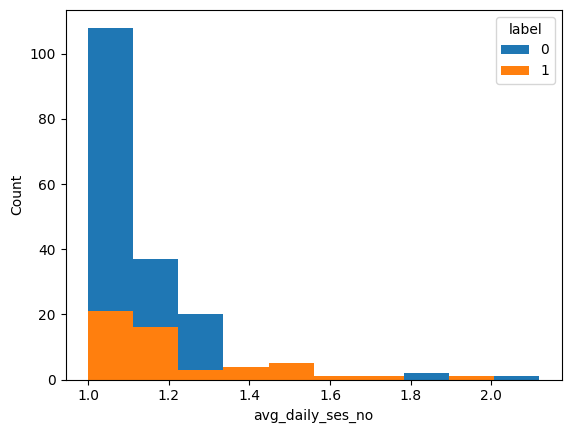

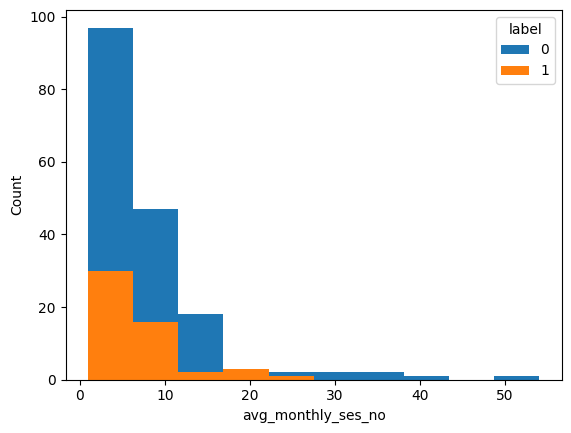

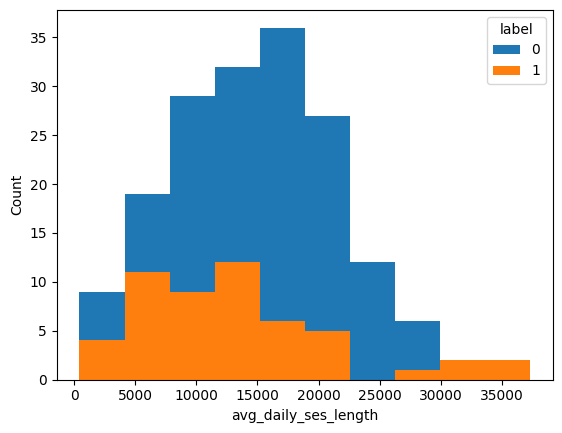

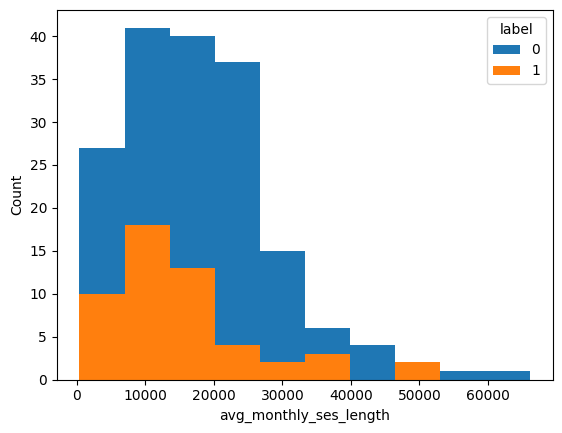

In [94]:
for col in num_columns:
    ax = pd_feat.pivot(columns='label', values = col).plot.hist()
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    plt.show()

# Modeling

In [75]:
# prepare data for pipeline
    #create dummy viariables for month_last_interaction, gender, location, last_level, page_status_before_churn
ind_month_last_interaction = StringIndexer(inputCol='month_last_interaction', outputCol='month_last_interaction_ind')
ind_gender = StringIndexer(inputCol='gender', outputCol='gender_ind')
ind_location = StringIndexer(inputCol='location', outputCol='location_ind')
ind_last_level = StringIndexer(inputCol='last_level', outputCol='last_level_ind')

    #VectorAssembler for numeric values
num_columns = []
for field in df_feat.schema.fields :
    if field.dataType!=StringType():
        num_columns.append(field.name)

num_columns.remove('label')

vec_assembler = VectorAssembler(inputCols=num_columns, outputCol='features')


Pipeline for tree based models. Due to small dataset I will split it into train and test datasets without validation dataset. I will also use stratified sampling as dataset is imbalanced. The best model will be later tuned. I will use area under PR curve as a main metric to evaluate model as the final dataset is imbalanced and the problem is to optimize positive class. 

Source: https://arize.com/blog/what-is-pr-auc/

In [76]:
# pipeline
pipeline_tree  = Pipeline(stages=[ind_month_last_interaction, ind_gender, ind_location, ind_last_level, 
                      vec_assembler])

# transform dataset with pipeline
model_df = pipeline_tree.fit(df_feat).transform(df_feat)

# stratified sampling based on churn
train_strat = model_df.sampleBy('label', fractions={0: 0.8, 1: 0.8}, seed=123)
test_strat = model_df.subtract(train_strat)
 

In [77]:
for ml_model in [RandomForestClassifier(), GBTClassifier()]:
    
    model = ml_model
    model_fit = model.fit(train_strat) 
    predictions_test =  model_fit.transform(test_strat)

    print(model)
# f1 score
    f1 = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1.evaluate(predictions_test.select(col('label'), col('prediction')))
    print('The F1 score for test dataset is {:.2%}'.format(f1_score)) 
# area under pr curve  
    pr = BinaryClassificationEvaluator()
    pr_value = pr.evaluate(predictions_test, {pr.metricName: "areaUnderPR"})
    print('The areaUnderPR for test dataset is {:.2%}'.format(pr_value))

RandomForestClassifier_7d92d15f4cc2


The F1 score for test dataset is 83.67%


The areaUnderPR for test dataset is 82.81%


GBTClassifier_b1b8eec4d7c0


25/03/04 12:04:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/04 12:04:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


The F1 score for test dataset is 91.47%


The areaUnderPR for test dataset is 83.81%


I will tune Gradient Boosting model as it gives the best results on Area under PR curve. I decide to focus on Area under PR metric as it is commonly used for heavily imbalanced datasets where you are optimizing for the positive class.

Source: https://arize.com/blog/what-is-pr-auc/

In [81]:
# model tuning

    # define ml model
rf = GBTClassifier(labelCol="label")

# parameter grid to tune ml model
paramGrid = ParamGridBuilder() \
        .addGrid(rf.maxIter, [20, 30]) \
        .addGrid(rf.maxBins, [10, 20, 32, 50]) \
        .addGrid(rf.maxDepth, [3, 5, 10]) \
        .build()
                 
crossval = CrossValidator(estimator = Pipeline(stages=[rf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

    # fit model on train set
rf_crossval = crossval.fit(train_strat)   

    # calculate predictions on test set
predictions_test =  rf_crossval.transform(test_strat)

    # evaluation metrics
print(rf)

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions_test.select(col('label'), col('prediction')))
print('The F1 score on the test set is {:.2%}'.format(f1_score)) 
#     
pr = BinaryClassificationEvaluator()
pr_value = pr.evaluate(predictions_test, {pr.metricName: "areaUnderPR"})
print('The areaUnderPR on the test set is {:.2%}'.format(pr_value))

bestPipeline = rf_crossval.bestModel

# prints feature importances
for i in range(len(bestPipeline.stages[0].featureImportances)):
    print("{} : {} \n".format(df_feat.columns[i], bestPipeline.stages[0].featureImportances[i]))

print('Best parameters : max depth:{}, num Bins:{}, num Iter:{}'.\
    format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getOrDefault('maxBins'), bestPipeline.stages[0].getOrDefault('maxIter')))

GBTClassifier_6afd8bf3750e


The F1 score on the test set is 91.20%


The areaUnderPR on the test set is 86.83%
month_last_interaction : 0.1637953099362304 

gender : 0.197273629855262 

location : 0.026092983256907423 

label : 0.0100035732742666 

registration_length : 0.16465457646731577 

n_artists : 0.08207197595637805 

n_songs : 0.11985187820255443 

last_level : 0.06325915755350914 

avg_length : 0.07583035213303745 

avg_itemInSession : 0.09716656336453855 

Best parameters : max depth:3, num Bins:10, num Iter:20


Gradient boosting classifier performed better than random forest classifier. Hyperparameter tuning was conducted for the gradient boosting with cross-validation and grid search to optimize the ML model. Tuned model F1 score is 91.2% and Area under PR Curve is 86.8% with parameters: max depth :3, bins number: 10 and iterations number: 20. Top 4 features are:  gender, how long a user is registered, month of last interaction for each user and number of songs played per user.

A limitation of this project is the use of a relatively small dataset, which results in fewer features. Larger dataset would make it possible to calculate more engineered features and to build a more robust model. Another problem while building the ML model was overfitting. Using to many features resulted in F1 score equal to 100% which is not true. 

In [ ]:
###
# model_df.select("label", "features").show()

In [ ]:
# # scale data
# scaler = MinMaxScaler(inputCol='features', outputCol="ScaledFeatures")

# # prepare pipeline
# pipeline_lr  = Pipeline(stages=[ind_month_last_interaction, ind_gender, ind_location, ind_last_level, 
#                       vec_assembler, scaler])
# #transform data with pipeline
# model_df_lr = pipeline_lr.fit(df_feat).transform(df_feat)

# # stratified sampling based on churn
# train_strat_lr = model_df_lr.sampleBy('label', fractions={0: 0.8, 1: 0.8}, seed=123)
# test_strat_lr = model_df_lr.subtract(train_strat_lr)



# # logistic regression with stratified sampling
# model_lr = LogisticRegression()

# model_fit_lr = model_lr.fit(train_strat) 
# predictions_test =  model_fit_lr.transform(test_strat)
    
# print(model_lr)
# # f1
# f1 = MulticlassClassificationEvaluator(metricName='f1')
# f1_score = f1.evaluate(predictions_test.select(col('label'), col('prediction')))
# print('The F1 score for test dataset is {:.2%}'.format(f1_score)) 
# #area under ROC curve   
# auc = BinaryClassificationEvaluator()
# auc_value = auc.evaluate(predictions_test, {auc.metricName: "areaUnderPR"})
# print('The areaUnderPR for test dataset is {:.2%}'.format(auc_value))

In [ ]:
# # define ml model
# lr = LogisticRegression()

# # parameter grid to tune ml model
# paramGrid = ParamGridBuilder() \
#     .addGrid(lr.maxIter, [500]) \
#     .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
#     .build()

# crossval = CrossValidator(estimator = Pipeline(stages=[lr]),
#                          estimatorParamMaps = paramGrid,
#                          evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR'),
#                          numFolds = 3)

#     # fit model on train set
# lr_crossval = crossval.fit(train_strat)   

#     # calculate predictions on test set
# predictions_test =  lr_crossval.transform(test_strat)

#     # evaluation metrics
# print(lr)

# f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
# f1_score = f1_score_evaluator.evaluate(predictions_test.select(col('label'), col('prediction')))
# print('The F1 score for test set is {:.2%}'.format(f1_score)) 
# #     
# auc_evaluator = BinaryClassificationEvaluator()
# metric_value = auc_evaluator.evaluate(predictions_test, {auc_evaluator.metricName: "areaUnderPR"})
# print('The areaUnderPR for test set is {:.2%}'.format(metric_value))

# bestPipeline = lr_crossval.bestModel

# prints feature importances
# for i in range(len(bestPipeline.stages[0].featureImportances)):
#     print("{} : {} \n".format(df_feat.columns[i], bestPipeline.stages[0].featureImportances[i]))

# print('Best parameters : maxIter:{}, regParam:{}'.\
#     format(bestPipeline.stages[0].getOrDefault('maxIter'), bestPipeline.stages[0].getOrDefault('regParam')))